# Exoplanet PyMC3 Tutorial

Text(0, 0.5, 'y')

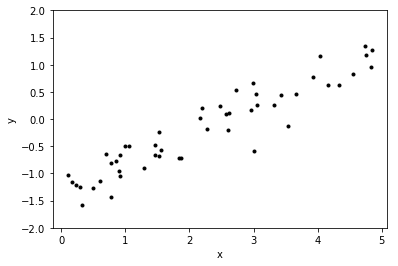

In [36]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_m = 0.5
true_b = -1.3
true_logs = np.log(0.3)

x = np.sort(np.random.uniform(0, 5, 50))
y = true_b + true_m * x + np.exp(true_logs) * np.random.randn(len(x))

plt.plot(x, y, ".k")
plt.ylim(-2, 2)
plt.xlabel("x")
plt.ylabel("y")

To fit a model to these data, our model will have 3 parameters: the slope 𝑚, the intercept 𝑏, and the log of the uncertainty log(𝜎)...

Another way of writing this model that might not be familiar is the following:

m ~ Uniform(-5, 5)

b ~ Uniform(-5, 5)

log($\sigma$) ~ Uniform(-5, 5)

y$_n$ ~ Uniform(m x$_n$ + b, $\sigma$)


-------------

Now, let’s implement this model in PyMC3. The documentation for the distributions available in PyMC3’s modeling language can be found here and these will come in handy as you go on to write your own models.


In [37]:
import pymc3 as pm

with pm.Model() as model:

    # Define the priors on each parameter:
    m = pm.Uniform("m", lower=-5, upper=5)
    b = pm.Uniform("b", lower=-5, upper=5)
    logs = pm.Uniform("logs", lower=-5, upper=5)

    # Define the likelihood. A few comments:
    #  1. For mathematical operations like "exp", you can't use
    #     numpy. Instead, use the mathematical operations defined
    #     in "pm.math".
    #  2. To condition on data, you use the "observed" keyword
    #     argument to any distribution. In this case, we want to
    #     use the "Normal" distribution (look up the docs for
    #     this).
    pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(logs), observed=y)

    # This is how you will sample the model. Take a look at the
    # docs to see that other parameters that are available.
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, b, m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


Now since we now have samples, let’s make some diagnostic plots. The first plot to look at is the “traceplot” implemented in PyMC3. In this plot, you’ll see the marginalized distribution for each parameter on the left and the trace plot (parameter value as a function of step number) on the right. In each panel, you should see two lines with different colors. These are the results of different independent chains and if the results are substantially different in the different chains then there is probably something going wrong.


/Users/Danielyahalomi/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


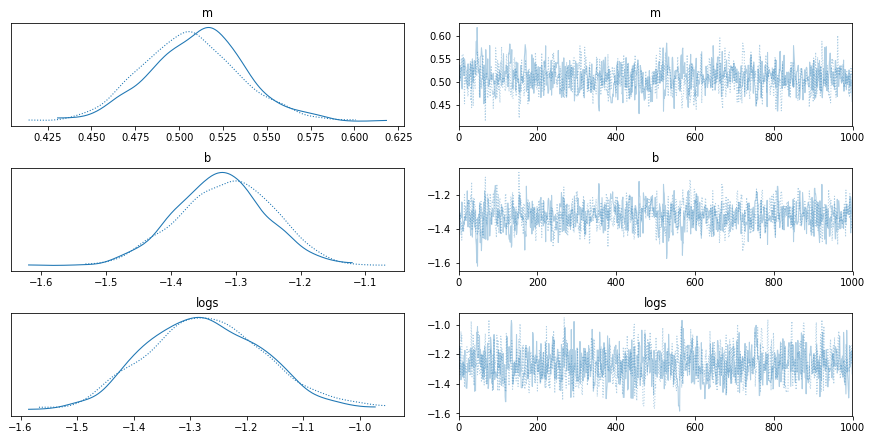

In [38]:
_ = pm.traceplot(trace, var_names=["m", "b", "logs"])

It’s also good to quantify that “looking substantially different” argument. This is implemented in PyMC3 as the “summary” function. In this table, some of the key columns to look at are ess_mean and r_hat. 

ess shows an estimate of the number of effective (or independent) samples for that parameter. In this case, ess should probably be around 500 per chain (there should have been 2 chains run).

r_hat shows the Gelman–Rubin statistic and it should be close to 1.



In [39]:
with model:
    print(pm.summary(trace, var_names=["m", "b", "logs"]))

       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
m     0.508  0.028   0.461    0.565      0.001    0.001     769.0   769.0   
b    -1.320  0.073  -1.457   -1.186      0.003    0.002     757.0   755.0   
logs -1.271  0.106  -1.452   -1.062      0.003    0.002     991.0   972.0   

      ess_bulk  ess_tail  r_hat  
m        772.0     859.0   1.01  
b        760.0     933.0   1.01  
logs     978.0     957.0   1.00  


The last diagnostic plot that we’ll make here is the corner plot made using corner.py. The easiest way to do this using PyMC3 is to first convert the trace to a Pandas DataFrame and then pass that to corner.py.

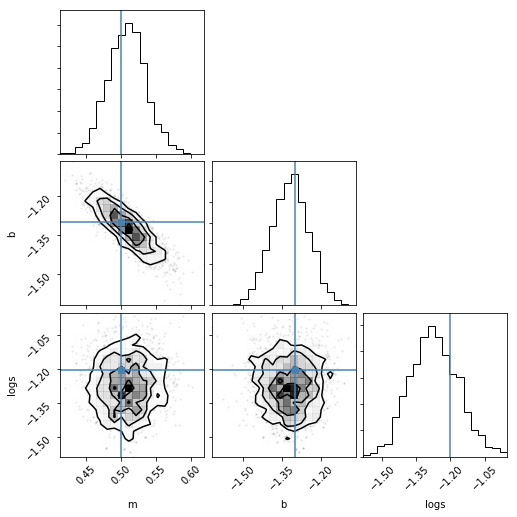

In [40]:
samples = pm.trace_to_dataframe(trace, varnames=["m", "b", "logs"])
_ = corner.corner(samples, truths=[true_m, true_b, true_logs])

Try initializing the parameters using the testval argument to the distributions. Does this improve performance in this case? It will substantially improve performance in more complicated examples.

- It increased preformance slightly as the errors on the parameters decreased to start the fit with the "true" values of m and b.


In [23]:
with pm.Model() as model:

    # Define the priors on each parameter:
    m = pm.Uniform("m", lower=-5, upper=5, testval = 0.5)
    b = pm.Uniform("b", lower=-5, upper=5, testval = -1.3)
    logs = pm.Uniform("logs", lower=-5, upper=5)

    # Define the likelihood. A few comments:
    #  1. For mathematical operations like "exp", you can't use
    #     numpy. Instead, use the mathematical operations defined
    #     in "pm.math".
    #  2. To condition on data, you use the "observed" keyword
    #     argument to any distribution. In this case, we want to
    #     use the "Normal" distribution (look up the docs for
    #     this).
    pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(logs), observed=y)

    # This is how you will sample the model. Take a look at the
    # docs to see that other parameters that are available.
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, b, m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


/Users/Danielyahalomi/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


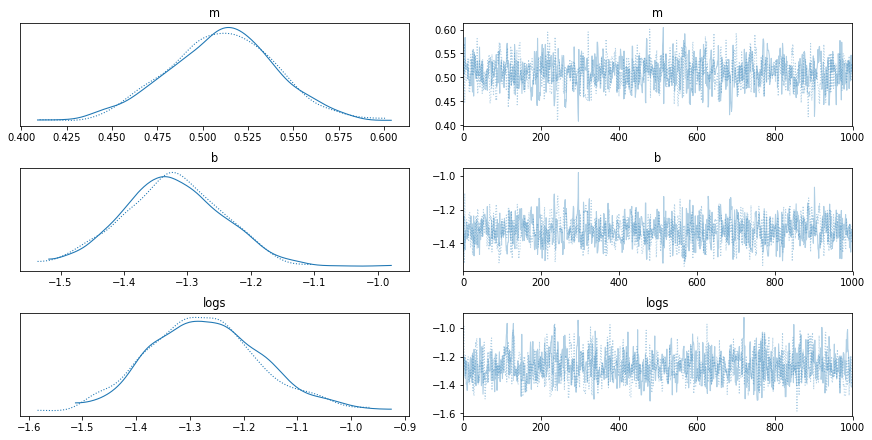

In [24]:
_ = pm.traceplot(trace, var_names=["m", "b", "logs"])

In [26]:
with model:
    print(pm.summary(trace, var_names=["m", "b", "logs"]))

       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
m     0.511  0.030   0.450    0.562      0.001    0.001     852.0   852.0   
b    -1.324  0.077  -1.465   -1.178      0.003    0.002     849.0   846.0   
logs -1.271  0.102  -1.481   -1.093      0.003    0.002     945.0   945.0   

      ess_bulk  ess_tail  r_hat  
m        855.0     853.0    1.0  
b        848.0    1093.0    1.0  
logs     946.0     870.0    1.0  


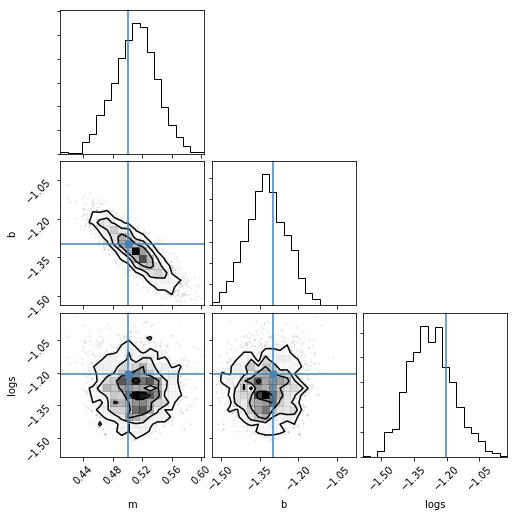

In [25]:
samples = pm.trace_to_dataframe(trace, varnames=["m", "b", "logs"])
_ = corner.corner(samples, truths=[true_m, true_b, true_logs])

What happens as you substantially increase or decrease the simulated noise? Does the performance change significantly? Why?
- Yes, increasing the noise increases the uncertainties on the different parameters. Decreasing the noise has the opposite effect. It is harder for the parameter to fit the original values as precisely, because introducing noise fundamentally distorts these "true" parameters. The more noise, the more distorted the values become.

Text(0, 0.5, 'y')

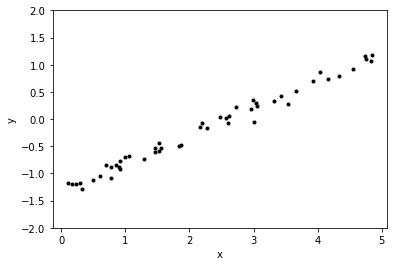

In [41]:
np.random.seed(42)

true_m = 0.5
true_b = -1.3
true_logs = np.log(0.1)

x = np.sort(np.random.uniform(0, 5, 50))
y = true_b + true_m * x + np.exp(true_logs) * np.random.randn(len(x))

plt.plot(x, y, ".k")
plt.ylim(-2, 2)
plt.xlabel("x")
plt.ylabel("y")



In [42]:
with pm.Model() as model:

    # Define the priors on each parameter:
    m = pm.Uniform("m", lower=-5, upper=5)
    b = pm.Uniform("b", lower=-5, upper=5)
    logs = pm.Uniform("logs", lower=-5, upper=5)

    # Define the likelihood. A few comments:
    #  1. For mathematical operations like "exp", you can't use
    #     numpy. Instead, use the mathematical operations defined
    #     in "pm.math".
    #  2. To condition on data, you use the "observed" keyword
    #     argument to any distribution. In this case, we want to
    #     use the "Normal" distribution (look up the docs for
    #     this).
    pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(logs), observed=y)

    # This is how you will sample the model. Take a look at the
    # docs to see that other parameters that are available.
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, b, m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


/Users/Danielyahalomi/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
m     0.503  0.010   0.486    0.523      0.000    0.000     792.0   792.0   
b    -1.308  0.026  -1.360   -1.263      0.001    0.001     833.0   833.0   
logs -2.368  0.106  -2.587   -2.190      0.003    0.002    1076.0  1068.0   

      ess_bulk  ess_tail  r_hat  
m        806.0     664.0    1.0  
b        852.0     764.0    1.0  
logs    1029.0     783.0    1.0  


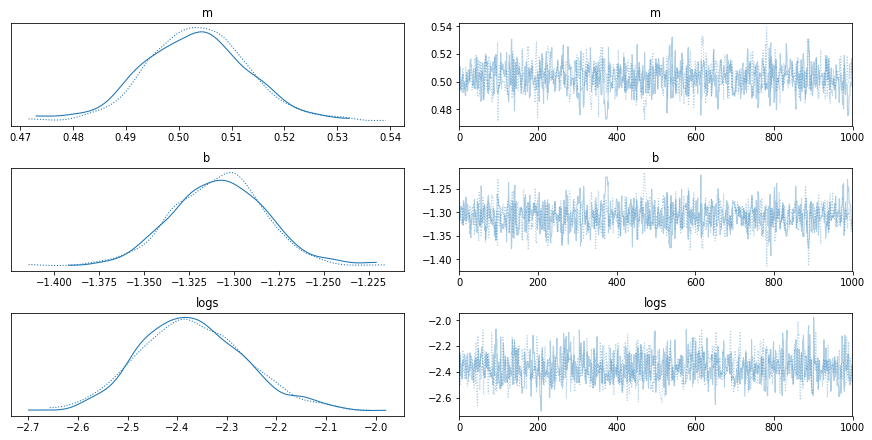

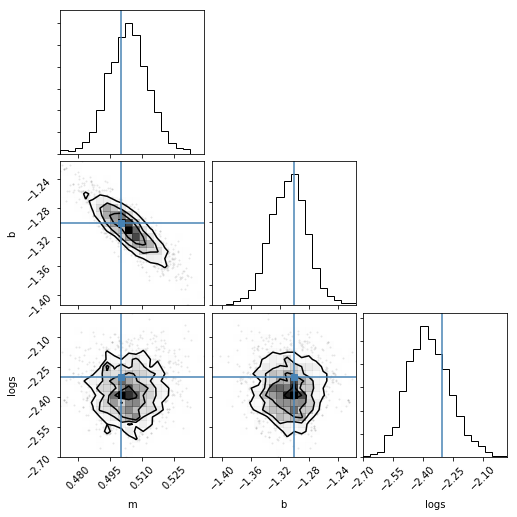

In [43]:
_ = pm.traceplot(trace, var_names=["m", "b", "logs"])

with model:
    print(pm.summary(trace, var_names=["m", "b", "logs"]))
    
samples = pm.trace_to_dataframe(trace, varnames=["m", "b", "logs"])
_ = corner.corner(samples, truths=[true_m, true_b, true_logs])

# Exoplanet RV Tutorial

In [17]:
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import exoplanet as xo

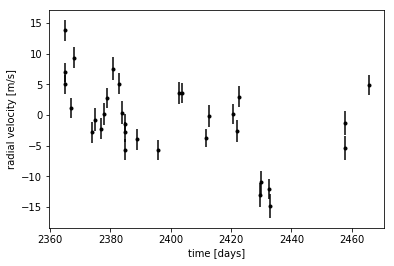

In [5]:
url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

In [6]:
periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


In [7]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=2, testval=np.array([0.1, 0.1])
    )
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

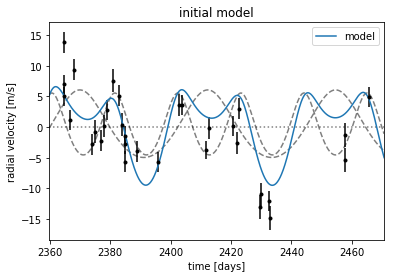

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [10]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -79.73266285618828 -> -64.84820262331533
optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -64.84820262331533 -> -14.276760262380861


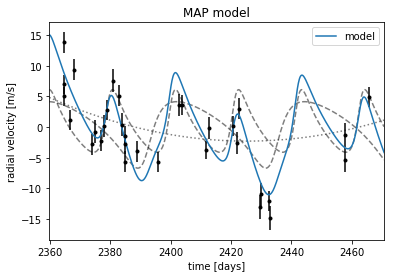

In [11]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

In [12]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        target_accept=0.95,
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 150 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
pm.summary(
    trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.001,-0.000,0.002,0.000,0.000,5045.0,5002.0,5083.0,4707.0,1.0
trend[1],-0.039,0.022,-0.082,0.002,0.000,0.000,6906.0,6083.0,7056.0,5273.0,1.0
trend[2],-1.975,0.804,-3.474,-0.464,0.011,0.008,5168.0,5168.0,5175.0,5195.0,1.0
logs,1.034,0.228,0.606,1.463,0.004,0.003,3516.0,3484.0,3519.0,4414.0,1.0
omega[0],-0.298,0.775,-1.393,1.334,0.016,0.015,2318.0,1377.0,2618.0,2014.0,1.0
omega[1],-0.544,2.133,-3.120,2.909,0.039,0.029,3050.0,2799.0,4424.0,6770.0,1.0
ecc[0],0.235,0.114,0.003,0.413,0.002,0.002,2718.0,2200.0,2832.0,1963.0,1.0
ecc[1],0.194,0.141,0.000,0.449,0.003,0.002,2553.0,2390.0,2517.0,3159.0,1.0
t0[0],2072.795,0.001,2072.794,2072.796,0.000,0.000,8022.0,8022.0,8094.0,6030.0,1.0
t0[1],2082.625,0.000,2082.624,2082.626,0.000,0.000,7671.0,7671.0,8278.0,5248.0,1.0


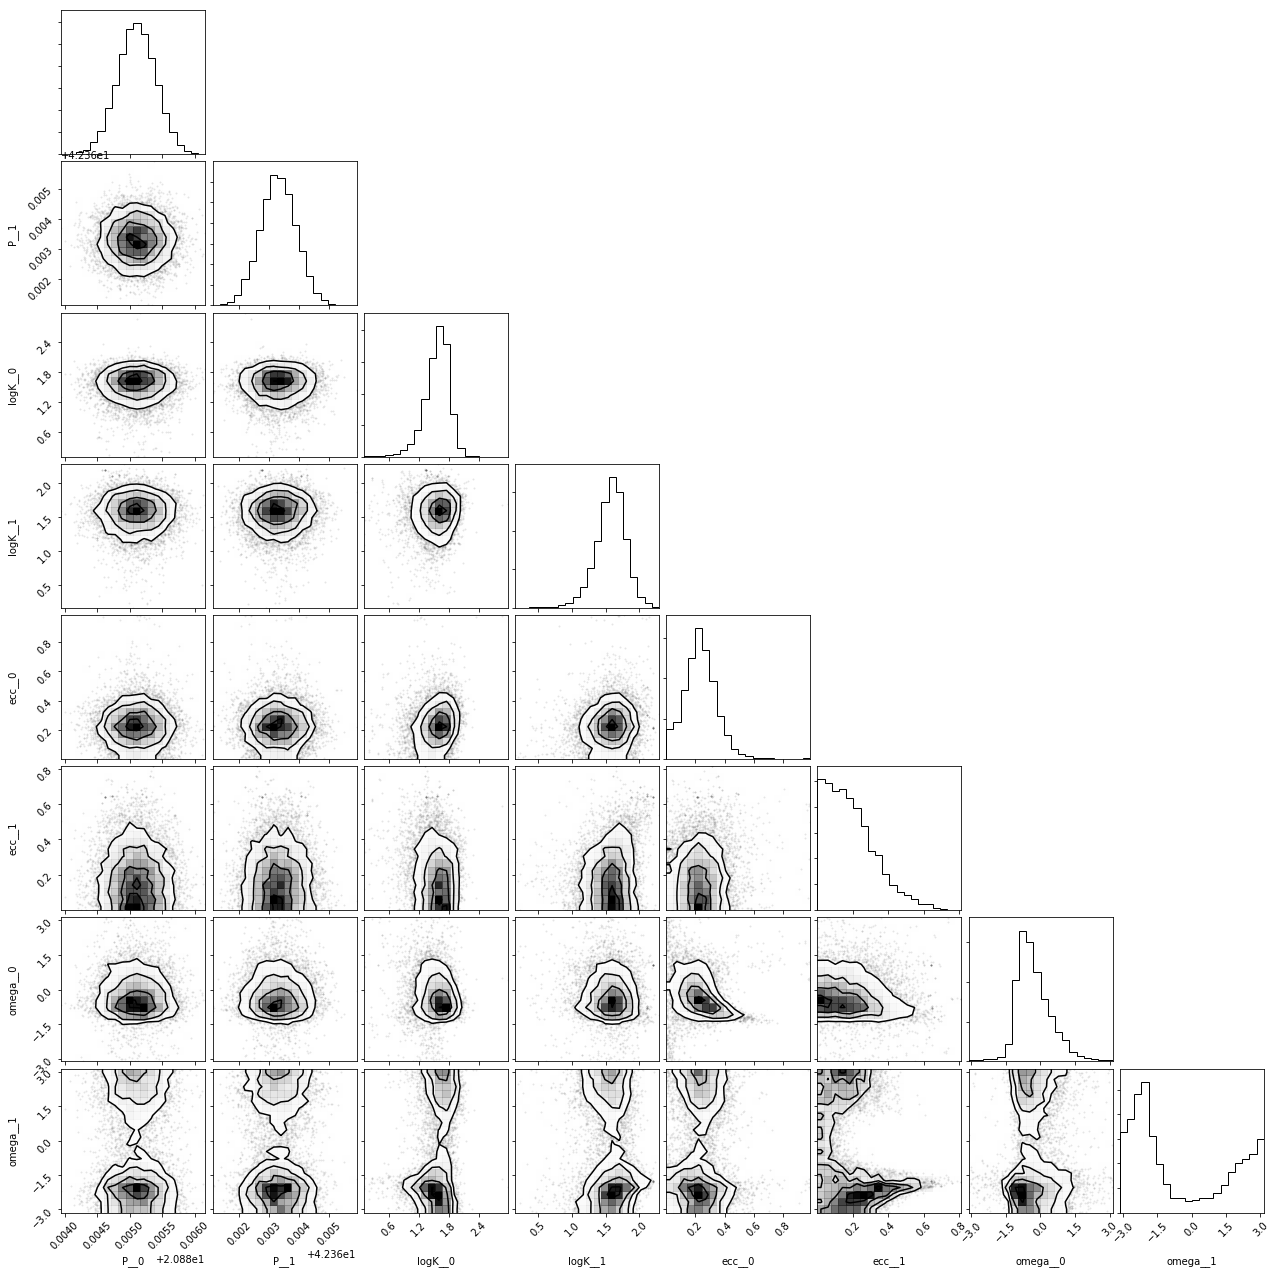

In [14]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
_ = corner.corner(samples)

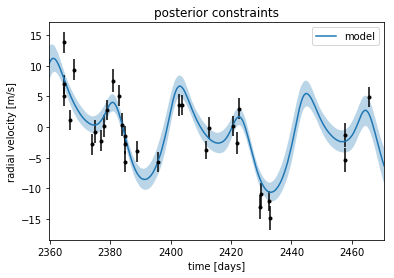

In [15]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")


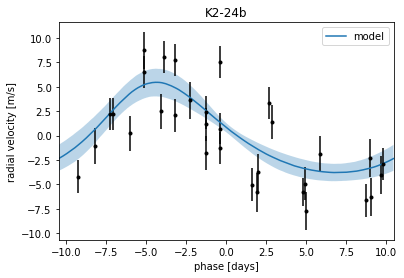

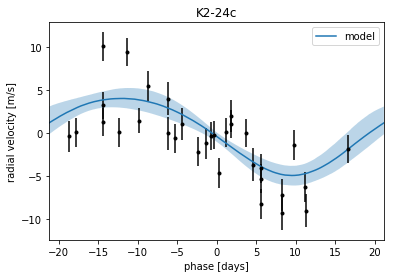

In [16]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

# The Joker Tutorial

(-10, 200)

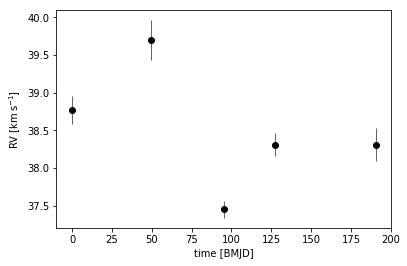

In [19]:
import thejoker as tj
t = [0., 49.452, 95.393, 127.587, 190.408]
rv = [38.77, 39.70, 37.45, 38.31, 38.31] * u.km/u.s
err = [0.184, 0.261, 0.112, 0.155, 0.223] * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)
ax = data.plot() 
ax.set_xlim(-10, 200) 

In [20]:
prior = tj.JokerPrior.default(P_min=2*u.day, P_max=256*u.day,
                              sigma_K0=30*u.km/u.s,
                              sigma_v=100*u.km/u.s)

In [21]:
joker = tj.TheJoker(prior)
prior_samples = prior.sample(size=100_000)
samples = joker.rejection_sample(data, prior_samples) 

(-5, 205)

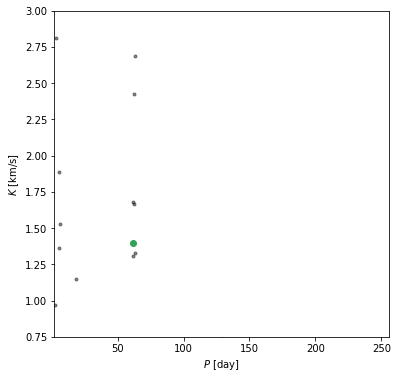

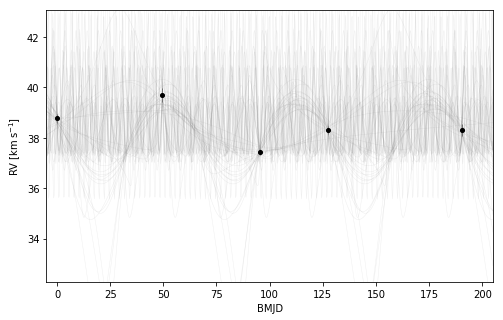

In [22]:
from thejoker import JokerPrior, TheJoker, RVData
from thejoker.plot import plot_rv_curves
import astropy.units as u

t = [0., 49.452, 95.393, 127.587, 190.408]
rv = [38.77, 39.70, 37.45, 38.31, 38.31] * u.km/u.s
err = [0.184, 0.261, 0.112, 0.155, 0.223] * u.km/u.s

data = RVData(t=t, rv=rv, rv_err=err)
prior = JokerPrior.default(P_min=2*u.day, P_max=256*u.day,
                           sigma_K0=30*u.km/u.s, sigma_v=100*u.km/u.s)
joker = TheJoker(prior)

prior_samples = prior.sample(size=100_000)
samples = joker.rejection_sample(data, prior_samples)

fig, ax = plt.subplots(1, 1, figsize=(6,6)) # doctest: +SKIP
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
           marker='.', color='k', alpha=0.45) # doctest: +SKIP
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")
ax.set_xlim(2, 256)
ax.set_ylim(0.75, 3.)

ax.scatter(61.942, 1.3959, marker='o', color='#31a354', zorder=-100)

fig, ax = plt.subplots(1, 1, figsize=(8,5)) # doctest: +SKIP
t_grid = np.linspace(-10, 210, 1024)
plot_rv_curves(samples, t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'))
ax.set_xlim(-5, 205)

# Exoplanet Astrometry Tutorial

In this tutorial we’ll walk through the simplest astrometric example with exoplanet and then explain how to build up a more complicated example with parallax measurements. For our dataset, we’ll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis a_ang measured in arcseconds, since the distance to the system is assumed to be unknown. We’ll work through this example first, then introduce the extra constraints provided by parallax information.

$\textbf{Data}$

First, let’s load and examine the data. We’ll use the astrometric measurements of HR 466 (HD 10009) as compiled by Pourbaix 1998. The speckle observations are originally from Hartkopf et al. 1996.



In [44]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of 1 degree in position angle and 0.01′′ in separation for the sake of specifying something, but we’ll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [46]:
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

Astrometric conventions
The conventions describing the orientation of the orbits are described in detail in the exoplanet paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is receeding from the observer (without radial velocity information, there is a 𝜋 degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range [0,𝜋]). The orbital inclination ranges from [0,𝜋]. 𝑖=0 describes a face-on orbit rotating counter-clockwise on the sky plane, while 𝑖=𝜋 describes a face-on orbit rotating clockwise on the sky. 𝑖=𝜋/2 is an edge-on orbit.

The observer frame 𝑋, 𝑌, 𝑍 is oriented on the sky such that +𝑍 points towards the observer, 𝑋 is the north axis, and 𝑌 is the east axis. All angles are measured in radians, and the position angle is returned in the range [−𝜋,𝜋], which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report 𝜔=𝜔secondary, whereas with an RV orbit it is generally common practice to report 𝜔=𝜔primary. The result is that unless the authors specify what they’re using, in a joint astrometric-RV orbit there is an ambiguity to which 𝜔 the authors mean, since 𝜔primary=𝜔secondary+𝜋. To standardize this across the exoplanet package, in all orbits (including astrometric-only) 𝜔=𝜔primary.

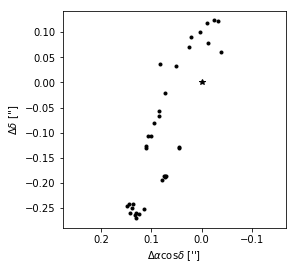

In [47]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the “raw” measurements are the values of 𝜌 (separation) and 𝜃 (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot 𝜌 vs. time and P.A. vs. time.



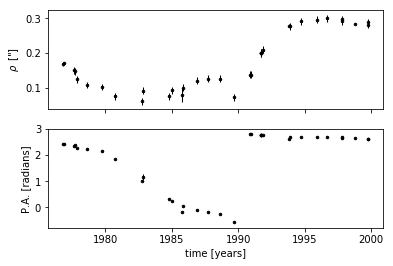

In [48]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

$\textbf{Fitting the astrometric orbit with exoplanet}$

To get started, let’s import the relative packages from exoplanet, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

.. note:: Orbits in *exoplanet* generally specify the semi-major axis in units of solar radii `R_sun`. For transits and RV orbits, you usually have enough external information (e.g., estimate of stellar mass from spectral type) to put a physical scale onto the orbit. For the most basic of astrometric orbits without parallax information, however, this information can be lacking and thus it makes sense to fit for the semi-major axis in units of `arcseconds`. But, `exoplanet` is modeling a real orbit (where semi-major axis is in units of `R_sun`), so we do need to at least provide a fake parallax to convert from arcseconds to `R_sun.`

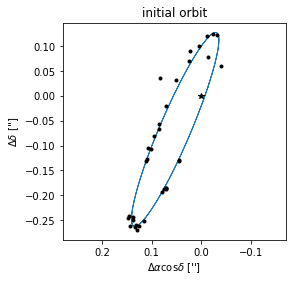

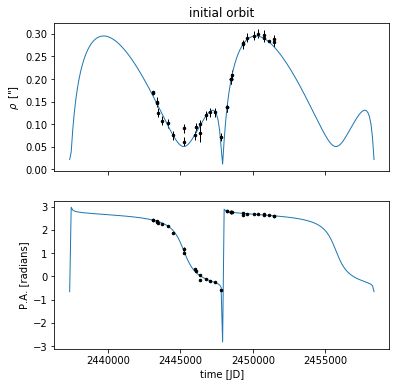

In [49]:
import pymc3 as pm
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

In [50]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]


message: Optimization terminated successfully.
logp: 104.85554109304482 -> 147.14399186005357
optimizing logp for variables: [phase]


message: Optimization terminated successfully.
logp: 147.14399186005357 -> 167.642205981972
optimizing logp for variables: [ecc, m, p]


message: Optimization terminated successfully.
logp: 167.642205981972 -> 210.0634066829792
optimizing logp for variables: [phase, a_ang, logP]


message: Optimization terminated successfully.
logp: 210.0634066829792 -> 210.50136989149493
optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


message: Optimization terminated successfully.
logp: 210.50136989149493 -> 215.02117742211843


Now that we have a maximum a posteriori estimate of the parameters, let’s take a look at the results to make sure that they seem reasonable.



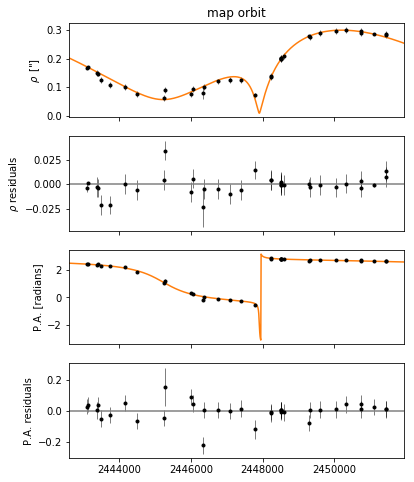

In [51]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

Now let’s sample the posterior.



In [52]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        cores=2,
        chains=2,
        init="adapt_full",
        target_accept=0.9,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 2 chains for 5_000 tune and 4_000 draw iterations (10_000 + 8_000 draws total) took 86 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.



In [54]:
with model:
    summary = pm.summary(
        trace,
        varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"],
    )
summary

/Users/Danielyahalomi/.local/lib/python3.6/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10378.638,120.030,10166.799,10603.468,5.064,3.615,562.0,552.0,881.0,401.0,1.0
tperi,2447861.108,19.538,2447823.626,2447897.369,0.316,0.223,3828.0,3828.0,3836.0,4627.0,1.0
a_ang,0.317,0.007,0.305,0.333,0.000,0.000,2251.0,2208.0,2445.0,902.0,1.0
omega,1.234,0.013,1.210,1.260,0.000,0.000,3023.0,3023.0,3024.0,3930.0,1.0
Omega,2.787,0.012,2.764,2.809,0.000,0.000,2171.0,2171.0,2196.0,2424.0,1.0
incl,1.692,0.006,1.680,1.703,0.000,0.000,2316.0,2316.0,2400.0,946.0,1.0
ecc,0.775,0.011,0.753,0.796,0.000,0.000,2225.0,2194.0,2281.0,968.0,1.0


That looks pretty good. Now here’s a corner plot showing the covariances between parameters.



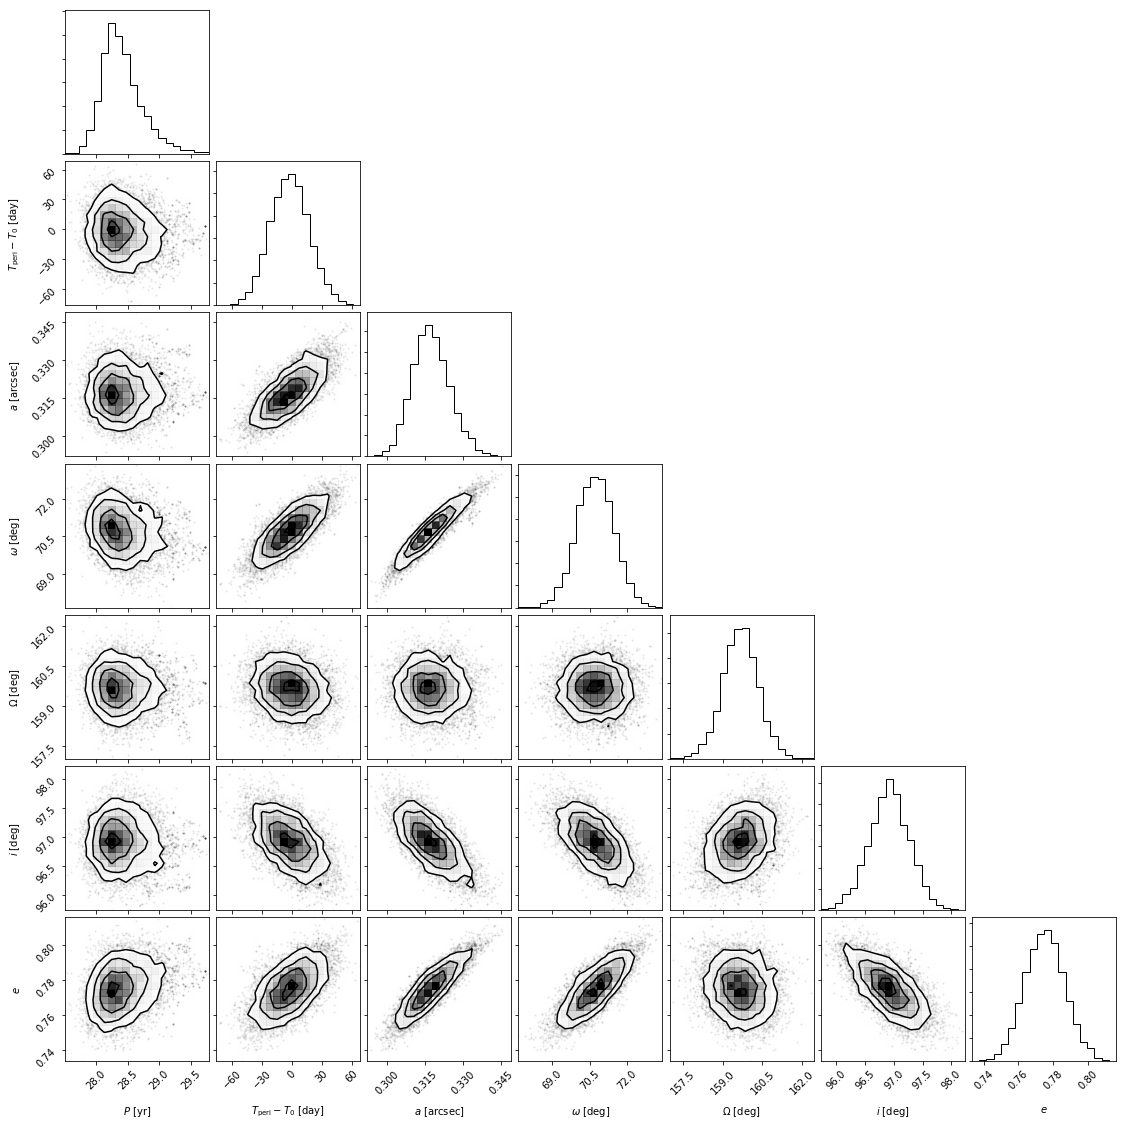

In [55]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

Finally, we can plot the posterior constraints on 𝜌 and 𝜃. This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

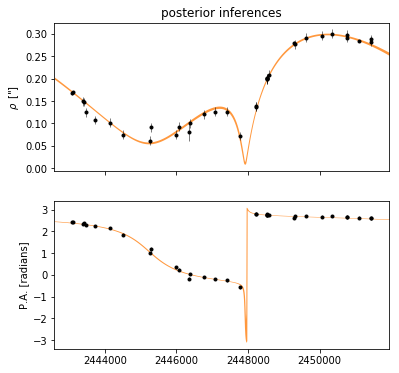

In [56]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0))
)
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry. We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit. It’s likely the uncertainties were not estimated correctly for these, and the simplistic jitter model we implemented isn’t sophisticated to apply more weight to only these discrepant points.